# Using ElasticNet Regression to Build a Binary (Two-Class) Classifier

In [1]:
from math import sqrt, fabs, exp
import matplotlib.pyplot as plt
from sklearn.linear_model import enet_path
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import seaborn as sns

sns.set()

In [2]:
# read data from UCI data repository
x_list = []
data_path = './data/sonar.all-data'

with open(data_path) as data:
    
    for line in data:
        # split on comma
        row = line.strip().split(',')
        x_list.append(row)
        
# separate labels from attributes, convert form attributes from string to numeric and convert 'M' to 1 and 'R' to 0

x_num = []
labels = []

for row in x_list:
    last_col = row.pop()
    
    if last_col == 'M':
        labels.append(1.0)
        
    else:
        labels.append(0.0)
        
    attr_row = [float(elt) for elt in row]
    x_num.append(attr_row)
    
# number of rows and columns in x matrix
n_row = len(x_num)
n_col = len(x_num[1])

alpha = 1.0

# calculate means and variances
x_means = []
x_sd = []

for i in range(n_col):
    col = [x_num[j][i] for j in range(n_row)]
    mean = sum(col)/n_row
    x_means.append(mean)
    
    col_diff = [(x_num[j][i] - mean) for j in range(n_row)]
    sum_sq = sum([col_diff[i] ** 2 for i in range(n_row)])
    std_dev = sqrt(sum_sq/n_row)
    x_sd.append(std_dev)
    
# use calculated mean and standard deviation to normalize x_num
x_normalized = []

for i in range(n_row):
    row_normalized = [(x_num[i][j] - x_means[j])/x_sd[j] for j in range(n_col)]
    x_normalized.append(row_normalized)
    
# normalize labels to center
mean_label = sum(labels)/n_row
sd_label = sqrt(sum([(labels[i] - mean_label) * (labels[i] - mean_label) for i in range(n_row)])/n_row)
label_normalized = [(labels[i] - mean_label)/sd_label for i in range(n_row)]

In [3]:
# number of cross-validation folds
n_x_val = 10

for i_x_val in range(n_x_val):
    # Define tst and training index sets
    idx_test = [a for a in range(n_row) if a % n_x_val == i_x_val % n_x_val]
    idx_train = [a for a in range(n_row) if a % n_x_val != i_x_val % n_x_val]
    
    # Define test and training attribute and label sets
    x_train = np.array([x_normalized[r] for r in idx_train])
    x_test = np.array([x_normalized[r] for r in idx_test])
    
    label_train = np.array([label_normalized[r] for r in idx_train])
    label_test = np.array([label_normalized[r] for r in idx_test])
    
    alphas, coefs, _ = enet_path(x_train, label_train, l1_ratio=0.8, fit_intercept=False, return_models=False)
    
    # apply coefs to test data to produce predictions and accumulate
    if i_x_val == 0:
        pred = np.dot(x_test, coefs)
        y_out = label_test
        
    else:
        # accumulate predictions
        y_temp = np.array(y_out)
        y_out = np.concatenate((y_temp, label_test), axis=0)
        
        # accumulate predictions
        pred_temp = np.array(pred)
        pred = np.concatenate((pred_temp, np.dot(x_test, coefs)), axis=0)

In [4]:
# calculate misclassification error
misclass_rate = []
_, n_pred = pred.shape

for i_pred in range(1, n_pred):
    pred_list = list(pred[:, i_pred])
    err_cnt = 0.0
    
    for i_row in range(n_row):
        
        if (pred_list[i_row] < 0.0) and (y_out[i_row] >= 0.0):
            err_cnt += 1.0
            
        elif (pred_list[i_row] >= 0.0) and (y_out[i_row] < 0.0):
            err_cnt += 1.0
            
    misclass_rate.append(err_cnt/n_row)

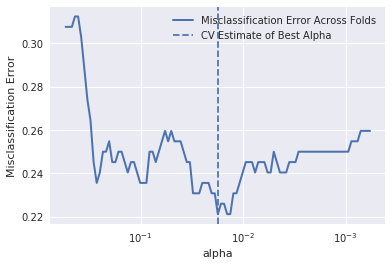

In [5]:
# find minimum point for plot and for print
min_err = min(misclass_rate)
idx_min = misclass_rate.index(min_err)
plot_alphas = list(alphas[1:len(alphas)])

plt.figure()
plt.plot(plot_alphas, misclass_rate, label='Misclassification Error Across Folds', linewidth=2)
plt.axvline(plot_alphas[idx_min], linestyle='--', label='CV Estimate of Best Alpha')
plt.legend()
plt.semilogx()
ax = plt.gca()
ax.invert_xaxis()
plt.xlabel('alpha')
plt.ylabel('Misclassification Error')
plt.axis('tight')
plt.show()

In [6]:
# calculate AUC
idx_pos = [i for i in range(n_row) if y_out[i] > 0.0]
y_out_bin = [0] * n_row

for i in idx_pos:
    y_out_bin[i] = 1
    
auc = []

for i_pred in range(1, n_pred):
    pred_list = list(pred[:, i_pred])
    auc_calc = roc_auc_score(y_out_bin, pred_list)
    auc.append(auc_calc)
    
max_auc = max(auc)
idx_max = auc.index(max_auc)

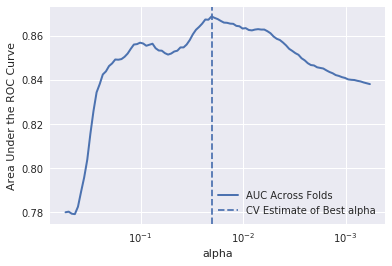

In [7]:
plt.figure()
plt.plot(plot_alphas, auc, label='AUC Across Folds', linewidth=2)
plt.axvline(plot_alphas[idx_max], linestyle='--', label='CV Estimate of Best alpha')
plt.legend()
plt.semilogx()
ax = plt.gca()
ax.invert_xaxis()
plt.xlabel('alpha')
plt.ylabel('Area Under the ROC Curve')
plt.axis('tight')
plt.show()

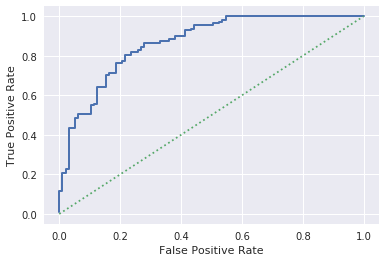

In [8]:
# plot best version of ROC curve
fpr, tpr, thresh = roc_curve(y_out_bin, pred[:, idx_max])
ct_class = [i * 0.01 for i in range(101)]

plt.plot(fpr, tpr, linewidth=2)
plt.plot(ct_class, ct_class, linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [9]:
print(f'Best Value of Misclassification Error = {misclass_rate[idx_min]}')
print(f'Best alpha of Misclassification Error = {plot_alphas[idx_min]}\n')
print(f'Best Value for AUC = {auc[idx_max]}')
print(f'Best alpha for AUC = {plot_alphas[idx_max]}')

Best Value of Misclassification Error = 0.22115384615384615
Best alpha of Misclassification Error = 0.017686244720179375

Best Value for AUC = 0.8686727965078481
Best alpha for AUC = 0.020334883589342503


In [10]:
print('Confusion Matrices for Different Threshold Values\n')

# pick some points along the curve to print.  There are 208 points.
# MN - Actually there are only 57 points, including in the original, unmodified code
# The extremes aren't useful

# Sample at 14, 28, and 42.  Use the calculated values of tpr and fpr along with definitions and threshold values.
# Some nomenclature (e.g. see wikipedia 'receiver operating curve')

# P = Positive cases
P = len(idx_pos)
# N = Negative cases
N = n_row - P

# TP = True positives = tpr * P
TP = tpr[14] * P
# FN = False negatives = P - TP
FN = P - TP
# FP = False positives = fpr * N
FP = fpr[14] * N
# TN = True negatives = N - FP
TN = N - FP

print(f'Threshold Value = {thresh[14]}')
print(f'TP = {TP}, FP = {FP}')
print(f'FN = {FN}, TN = {TN}\n')

TP = tpr[28] * P
FN = P - TP
FP = fpr[28] * N
TN = N - FP

print(f'Threshold Value = {thresh[28]}')
print(f'TP = {TP}, FP = {FP}')
print(f'FN = {FN}, TN = {TN}\n')

TP = tpr[42] * P
FN = P - TP
FP = fpr[42] * N
TN = N - FP

print(f'Threshold Value = {thresh[42]}')
print(f'TP = {TP}, FP = {FP}')
print(f'FN = {FN}, TN = {TN}')

Confusion Matrices for Different Threshold Values

Threshold Value = 0.21560082129000624
TP = 61.00000000000001, FP = 11.0
FN = 49.99999999999999, TN = 86.0

Threshold Value = -0.0943518921616662
TP = 89.0, FP = 23.0
FN = 22.0, TN = 74.0

Threshold Value = -0.32236938187194963
TP = 100.0, FP = 40.0
FN = 11.0, TN = 57.0
